# Introduction

This notebooks presents custom **Data Generator** combined with **ConvNet** and applied to [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset.

# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Limit TensorFlow GPU memory usage

In [2]:
import tensorflow as tf
gpu_options = tf.GPUOptions(allow_growth=True)  # init TF ...
config=tf.ConfigProto(gpu_options=gpu_options)  # w/o taking ...
with tf.Session(config=config): pass            # all GPU memory

# CIFAR-10 Dataset

Load dataset and show example images

In [3]:
(x_train_raw, y_train_raw), (x_test_raw, y_test_raw) = tf.keras.datasets.cifar10.load_data()
class2txt = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Show example images

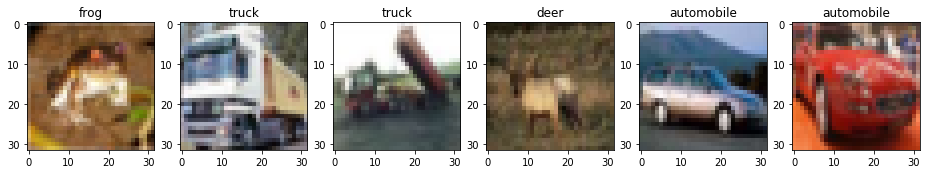

In [4]:
fig, axes = plt.subplots(nrows=1, ncols=6, figsize=[16, 9])
for i in range(len(axes)):
    axes[i].set_title(class2txt[y_train_raw[i, 0]])
    axes[i].imshow(x_train_raw[i])

Normalize features

In [5]:
x_train = (x_train_raw - x_train_raw.mean()) / x_train_raw.std()
x_test = (x_test_raw - x_train_raw.mean()) / x_train_raw.std()
print('x_train.shape', x_train.shape)
print('x_test.shape', x_test.shape)

x_train.shape (50000, 32, 32, 3)
x_test.shape (10000, 32, 32, 3)


One-hot encode labels

In [6]:
y_train = tf.keras.utils.to_categorical(y_train_raw, num_classes=10)
y_test = tf.keras.utils.to_categorical(y_test_raw, num_classes=10)
print('y_train.shape', y_train.shape)
print(y_train[:3])

y_train.shape (50000, 10)
[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


# Custom Generator

In [7]:
class CustomSequence(tf.keras.utils.Sequence):

    def __init__(self, data_x, data_y, batch_size, shuffle=False):
        """Custom data generator for model.fit_generator()
        
        Params:
            data_x - np.ndarray with features, shape (dataset_size, ...)
            data_y - np.ndarray with targets, shape (dataset_size, ...)
            batch_size - mini-batch size
            shuffle - shuffle features/targets between epochs
            
        Note:
            this class 'shuffle' param will shuffle all examples between epochs
            model.fit_generator(shuffle=...) param shufles order of mini-batches,
                but does not touch what is inside mini-batch
        """
        self.data_x = data_x
        self.data_y = data_y
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.data_x) / self.batch_size))

    def __getitem__(self, idx):
        batch_i = self.indices[idx*self.batch_size : (idx+1)*self.batch_size]
        batch_x = self.data_x[batch_i]
        batch_y = self.data_y[batch_i]

        return batch_x, batch_y

    def on_epoch_end(self):
        self.indices = np.arange(len(self.data_x))
        if self.shuffle:
            np.random.shuffle(self.indices)

Create generators

In [8]:
train_generator = CustomSequence(x_train, y_train, batch_size=250, shuffle=True)
test_generator = CustomSequence(x_test, y_test, batch_size=250)

Show examples

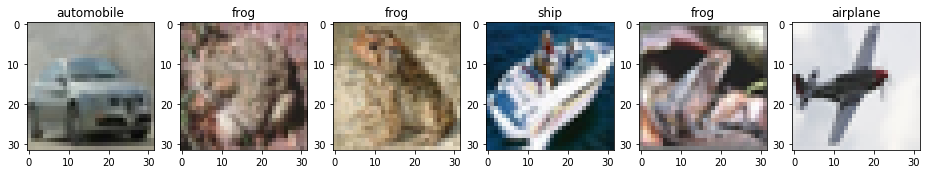

In [9]:
batch_x, batch_y = train_generator[0]
batch_x = ( batch_x * x_train_raw.std() + x_train_raw.mean() ) / 255.0

fig, axes = plt.subplots(nrows=1, ncols=6, figsize=[16, 9])
for i in range(len(axes)):
    axes[i].set_title(class2txt[np.argmax(batch_y[i])])
    axes[i].imshow(batch_x[i])

# Keras Model

In [10]:
from tensorflow.keras.layers import Input, InputLayer, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Flatten, Dense, Dropout

Define model

In [11]:
model = tf.keras.Sequential()
model.add(InputLayer(input_shape=[32, 32, 3]))

model.add(Conv2D(filters=16, kernel_size=3, padding='same', activation='elu'))
model.add(MaxPooling2D(pool_size=[2,2], strides=[2, 2], padding='same'))

model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='elu'))
model.add(MaxPooling2D(pool_size=[2,2], strides=[2, 2], padding='same'))

model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='elu'))
model.add(MaxPooling2D(pool_size=[2,2], strides=[2, 2], padding='same'))

model.add(Flatten())
model.add(Dropout(0.2))

model.add(Dense(512, activation='elu'))
model.add(Dropout(0.2))

model.add(Dense(10, activation='softmax'))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [12]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 64)          18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
__________

Train model

In [13]:
hist = model.fit_generator(train_generator, epochs=20,
                           validation_data=test_generator, verbose=2)

Instructions for updating:
Use tf.cast instead.
Epoch 1/20
40/40 [==============================] - 0s 10ms/step - loss: 1.1723 - acc: 0.5957
 - 4s - loss: 1.4643 - acc: 0.4821 - val_loss: 1.1723 - val_acc: 0.5957
Epoch 2/20
40/40 [==============================] - 0s 8ms/step - loss: 1.0428 - acc: 0.6392
 - 3s - loss: 1.1251 - acc: 0.6056 - val_loss: 1.0428 - val_acc: 0.6392
Epoch 3/20
40/40 [==============================] - 0s 8ms/step - loss: 1.0103 - acc: 0.6519
 - 3s - loss: 1.0131 - acc: 0.6466 - val_loss: 1.0103 - val_acc: 0.6519
Epoch 4/20
40/40 [==============================] - 0s 8ms/step - loss: 0.9211 - acc: 0.6783
 - 3s - loss: 0.9504 - acc: 0.6676 - val_loss: 0.9211 - val_acc: 0.6783
Epoch 5/20
40/40 [==============================] - 0s 8ms/step - loss: 0.8984 - acc: 0.6881
 - 3s - loss: 0.8827 - acc: 0.6923 - val_loss: 0.8984 - val_acc: 0.6881
Epoch 6/20
40/40 [==============================] - 0s 8ms/step - loss: 0.8474 - acc: 0.7083
 - 3s - loss: 0.8394 - acc: 0.705

Final results

In [14]:
loss, acc = model.evaluate(x_train, y_train, batch_size=250, verbose=0)
print(f'Accuracy on train set: {acc:.3f}')
loss, acc = model.evaluate(x_test, y_test, batch_size=250, verbose=0)
print(f'Accuracy on test set:  {acc:.3f}')

Accuracy on train set: 0.957
Accuracy on test set:  0.771


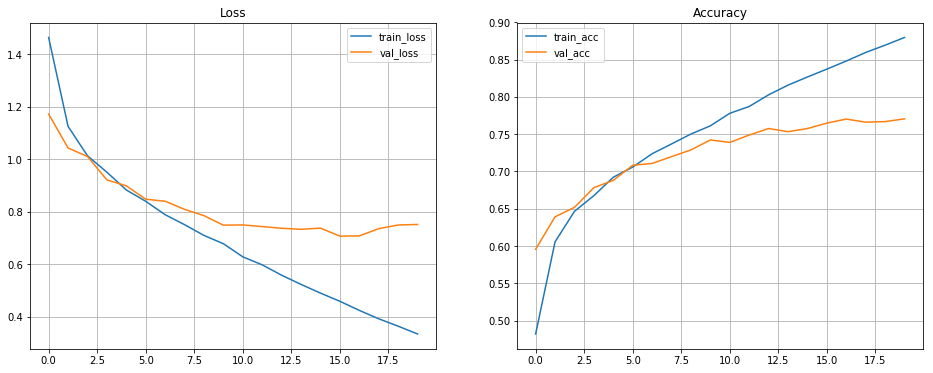

In [15]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[16, 6])
axes[0].plot(hist.history['loss'], label='train_loss')
axes[0].plot(hist.history['val_loss'], label='val_loss')
axes[0].set_title('Loss')
axes[0].legend()
axes[0].grid()
axes[1].plot(hist.history['acc'], label='train_acc')
axes[1].plot(hist.history['val_acc'], label='val_acc')
axes[1].set_title('Accuracy')
axes[1].legend()
axes[1].grid()